In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.utils import class_weight
import xgboost as xgb
import warnings

In [8]:
# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# --- 1. Data Loading and Initial Preparation ---
print("--- Loading and Preparing Data ---")

# Load the dataset with appropriate encoding
df = pd.read_csv('water_dataX.csv', encoding='ISO-8859-1')

# Clean up column names: remove special characters, spaces, and standardize
df.columns = [
    'STATION CODE', 'LOCATIONS', 'STATE', 'Temp', 'D.O.', 'PH',
    'CONDUCTIVITY', 'B.O.D.', 'NITRATE_N_NITRITE_N',
    'FECAL_COLIFORM', 'TOTAL_COLIFORM', 'year'
]

# Replace 'NAN' strings with actual NaN values for proper handling
df.replace('NAN', np.nan, inplace=True)

# Select only the numeric columns relevant for WQI calculation and modeling
numeric_cols = [
    'Temp', 'D.O.', 'PH', 'CONDUCTIVITY', 'B.O.D.',
    'NITRATE_N_NITRITE_N', 'FECAL_COLIFORM'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

print(f"Data from 'water_dataX.csv' loaded and columns cleaned successfully.")

--- Loading and Preparing Data ---
Data from 'water_dataX.csv' loaded and columns cleaned successfully.


In [9]:

# --- 2. WQI and WQC Calculation (Crucial Step) ---
# This section calculates the target variables based on standard formulas.
print("\n--- Calculating Water Quality Index (WQI) and Classification (WQC) ---")

# a. Drop rows where essential parameters for WQI are missing
df_wqi = df.dropna(subset=numeric_cols).copy()
df_wqi.reset_index(drop=True, inplace=True)

# b. Calculate quality rating (qn) for each parameter
# MODIFICATION: Added .clip(0, 100) to each calculation to cap the quality rating.
# This prevents extreme outliers in the calculated WQI and stabilizes the regression model.
# pH
df_wqi['npH'] = df_wqi.PH.apply(lambda x: (100 - 0) * (x - 7.0) / (8.5 - 7.0) if (x > 7) else (100 - 0) * (7.0 - x) / (7.0 - 6.5)).clip(0, 100)
# Dissolved Oxygen (D.O.)
df_wqi['ndo'] = df_wqi['D.O.'].apply(lambda x: (100 - 0) * (x - 14.6) / (5 - 14.6)).clip(0, 100)
# Biochemical Oxygen Demand (B.O.D.)
df_wqi['nbdo'] = df_wqi['B.O.D.'].apply(lambda x: (100 - 0) * (x - 0) / (5 - 0)).clip(0, 100)
# Fecal Coliform
df_wqi['nfc'] = df_wqi['FECAL_COLIFORM'].apply(lambda x: (100 - 0) * (x - 0) / (100 - 0)).clip(0, 100)
# Conductivity
df_wqi['nec'] = df_wqi['CONDUCTIVITY'].apply(lambda x: (100 - 0) * (x - 0) / (1000 - 0)).clip(0, 100)
# Nitrate
df_wqi['nnan'] = df_wqi['NITRATE_N_NITRITE_N'].apply(lambda x: (100 - 0) * (x - 0) / (20 - 0)).clip(0, 100)

# c. Assign weights (wn) based on parameter importance
w_ph, w_do, w_bdo, w_fc, w_ec, w_nan = 0.12, 0.28, 0.23, 0.18, 0.09, 0.10

# d. Calculate WQI
df_wqi['wqi'] = (df_wqi.npH * w_ph +
                 df_wqi.ndo * w_do +
                 df_wqi.nbdo * w_bdo +
                 df_wqi.nfc * w_fc +
                 df_wqi.nec * w_ec +
                 df_wqi.nnan * w_nan)

# e. Classify WQI into WQC categories
df_wqi['wqc'] = pd.cut(df_wqi['wqi'],
                       bins=[-1, 25, 50, 75, 100, float('inf')],
                       labels=['Excellent', 'Good', 'Poor', 'Very Poor', 'Unfit for Drinking'],
                       right=True)

print("WQI and WQC calculated and added to the dataframe.")


--- Calculating Water Quality Index (WQI) and Classification (WQC) ---
WQI and WQC calculated and added to the dataframe.



--- Performing Exploratory Data Analysis ---
Dataset Head:
  STATION CODE                                          LOCATIONS STATE  Temp  \
0         1399  ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...   GOA  29.8   
1         1475                                ZUARI AT PANCHAWADI   GOA  29.5   
2         3181                        RIVER ZUARI AT BORIM BRIDGE   GOA  29.7   
3         3182                       RIVER ZUARI AT MARCAIM JETTY   GOA  29.5   
4         1400             MANDOVI AT NEGHBOURHOOD OF PANAJI, GOA   GOA  30.0   

   D.O.   PH  CONDUCTIVITY  B.O.D.  NITRATE_N_NITRITE_N  FECAL_COLIFORM  \
0   5.7  7.2         189.0     2.0                  0.2          4953.0   
1   6.3  6.9         179.0     1.7                  0.1          3243.0   
2   5.8  6.9          64.0     3.8                  0.5          5382.0   
3   5.8  7.3          83.0     1.9                  0.4          3428.0   
4   5.5  7.4          81.0     1.5                  0.1          2853.0   

  

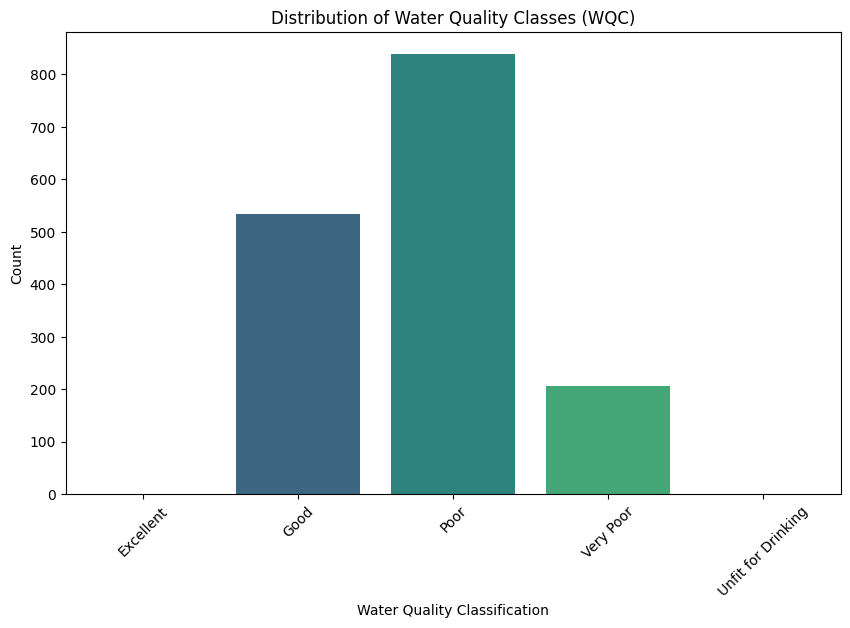

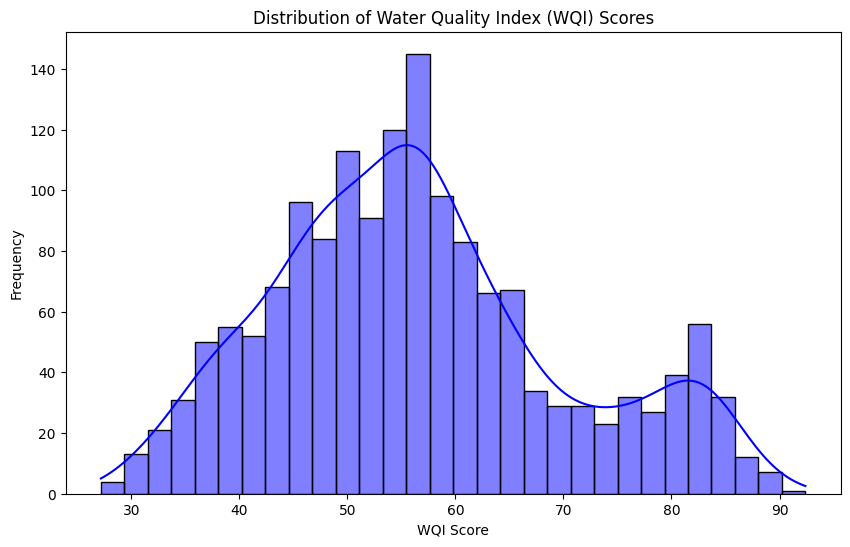

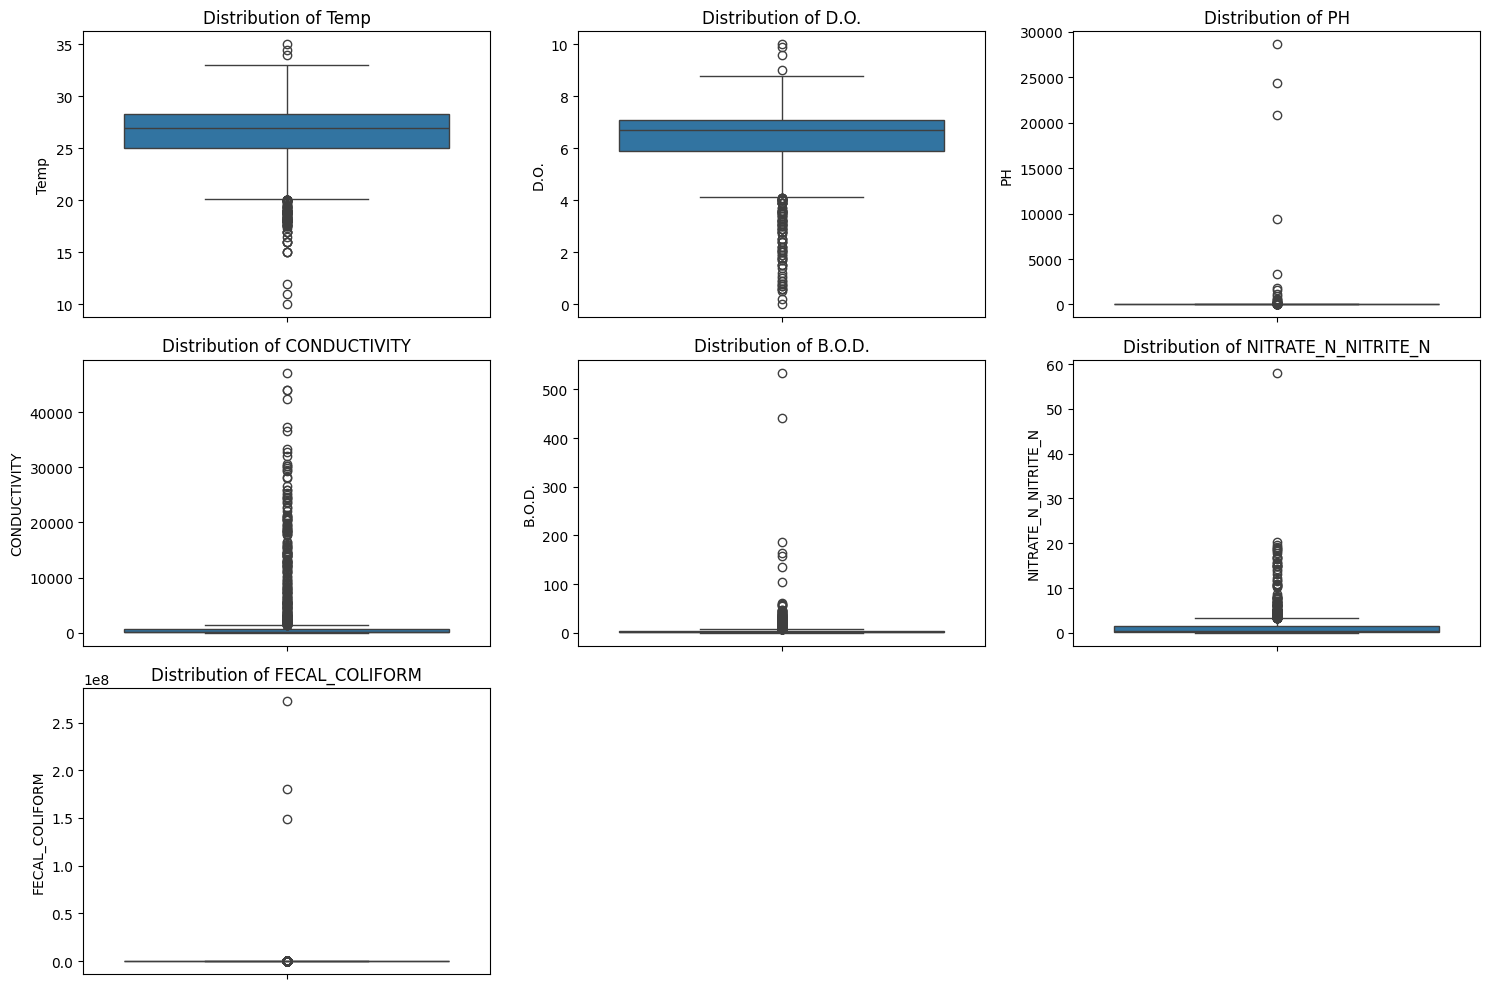

In [10]:

# --- 3. Exploratory Data Analysis (EDA) ---
print("\n--- Performing Exploratory Data Analysis ---")
print("Dataset Head:")
print(df_wqi.head())
print("\nDataset Info:")
df_wqi.info()

# NEW VISUALIZATION: WQC Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='wqc', data=df_wqi, palette='viridis')
plt.title('Distribution of Water Quality Classes (WQC)')
plt.xlabel('Water Quality Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# NEW VISUALIZATION: WQI Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_wqi['wqi'], kde=True, bins=30, color='blue')
plt.title('Distribution of Water Quality Index (WQI) Scores')
plt.xlabel('WQI Score')
plt.ylabel('Frequency')
plt.show()

# NEW VISUALIZATION: Feature Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df_wqi[col])
    plt.title(f'Distribution of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


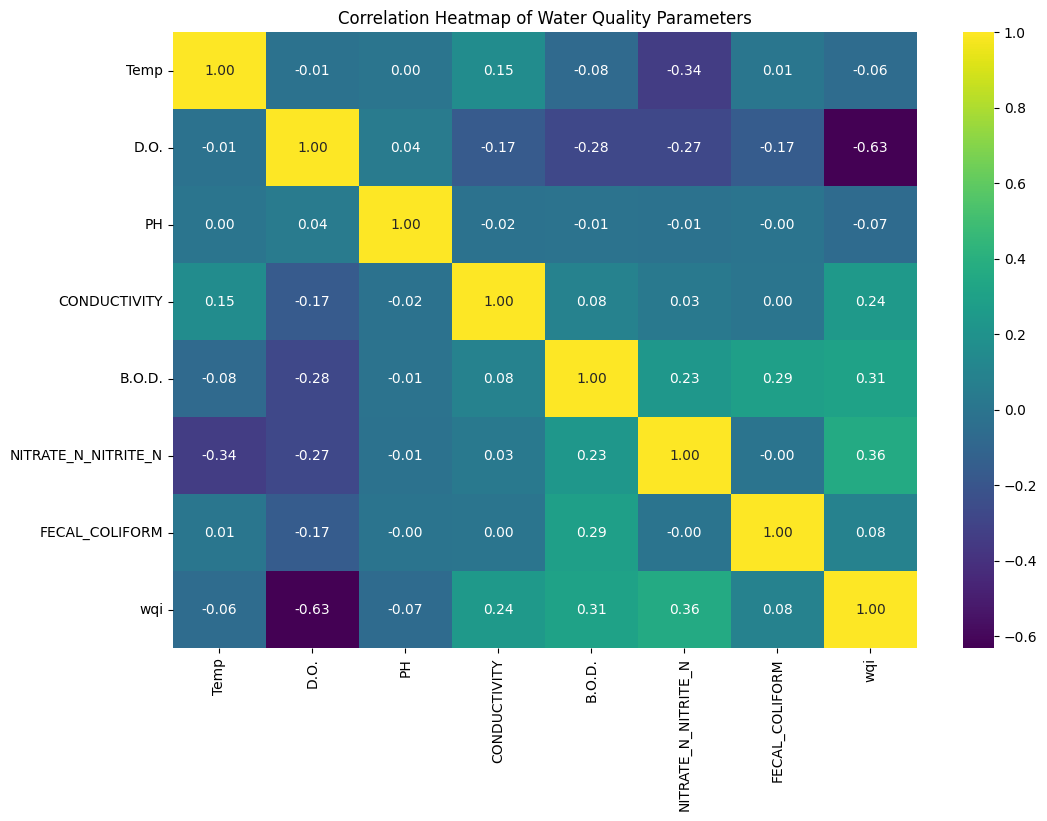


--- Preparing Data for Modeling ---
Data split into training and testing sets. Training samples: 1262, Testing samples: 316


In [11]:

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_wqi[numeric_cols + ['wqi']].corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap of Water Quality Parameters')
plt.show()

# --- 4. Feature Selection and Data Splitting ---
print("\n--- Preparing Data for Modeling ---")
X = df_wqi[numeric_cols].copy()

# MODIFICATION: Apply log transformation to skewed features to handle outliers
for col in ['CONDUCTIVITY', 'B.O.D.', 'FECAL_COLIFORM', 'NITRATE_N_NITRITE_N']:
    X[col] = np.log1p(X[col])

y_wqc = df_wqi['wqc']
y_wqi = df_wqi['wqi']

# Encode the categorical WQC labels
le = LabelEncoder()
y_wqc_encoded = le.fit_transform(y_wqc)

# Split data for WQC (Classification)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_wqc_encoded, test_size=0.2, random_state=42, stratify=y_wqc_encoded)

# Split data for WQI (Regression)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_wqi, test_size=0.2, random_state=42)

print(f"Data split into training and testing sets. Training samples: {len(X_train_c)}, Testing samples: {len(X_test_c)}")

In [12]:

# --- 5. Feature Scaling ---
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

print("Feature scaling applied.")


Feature scaling applied.


In [13]:

# --- 6. WQC (Classification) Model Training and Tuning ---
print("\n--- Building WQC (Classification) Model ---")
print("Tuning XGBoost Classifier with RandomizedSearchCV...")

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Hyperparameter grid for RandomizedSearchCV
params_c = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 12],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# MODIFICATION: Increased n_iter for a more thorough search
random_search_c = RandomizedSearchCV(xgb_clf, param_distributions=params_c, n_iter=100, cv=3, verbose=1, n_jobs=-1, random_state=42)

# MODIFICATION: Calculate and use sample weights to handle class imbalance
sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_c)
random_search_c.fit(X_train_c_scaled, y_train_c, sample_weight=sample_weights)

best_clf = random_search_c.best_estimator_
print(f"Best Classifier Parameters: {random_search_c.best_params_}")



--- Building WQC (Classification) Model ---
Tuning XGBoost Classifier with RandomizedSearchCV...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Classifier Parameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.8}



--- WQC Model Evaluation ---
Achieved Accuracy: 0.9335

Classification Report:
              precision    recall  f1-score   support

        Good       0.92      0.94      0.93       107
        Poor       0.95      0.93      0.94       168
   Very Poor       0.93      0.93      0.93        41

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316



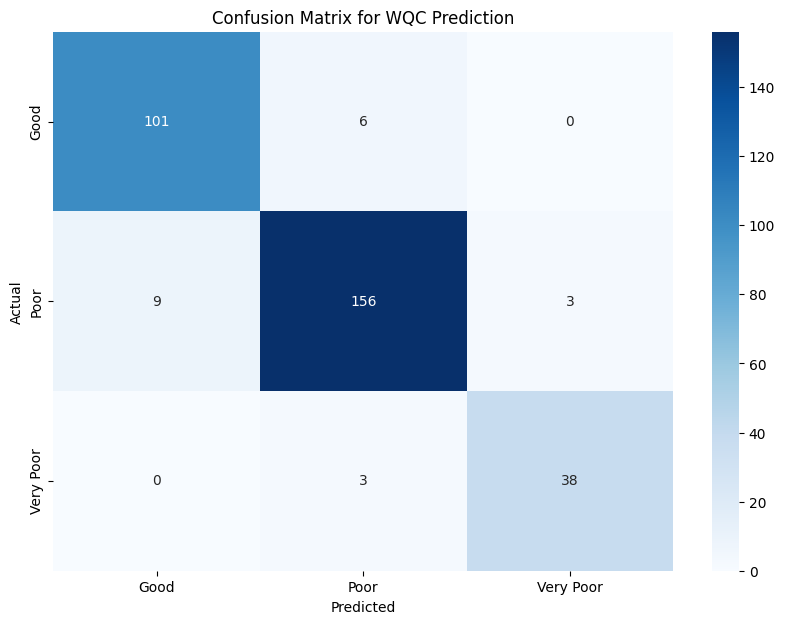

In [14]:

# --- 7. WQC (Classification) Evaluation ---
print("\n--- WQC Model Evaluation ---")
y_pred_c = best_clf.predict(X_test_c_scaled)
accuracy = accuracy_score(y_test_c, y_pred_c)
print(f"Achieved Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_c, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for WQC Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [15]:

# --- 8. WQI (Regression) Model Training and Tuning ---
print("\n--- Building WQI (Regression) Model ---")
print("Tuning XGBoost Regressor with RandomizedSearchCV...")

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

# Hyperparameter grid
params_r = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# MODIFICATION: Increased n_iter for a more thorough search
random_search_r = RandomizedSearchCV(xgb_reg, param_distributions=params_r, n_iter=100, cv=3, verbose=1, n_jobs=-1, random_state=42)
random_search_r.fit(X_train_r_scaled, y_train_r)

best_reg = random_search_r.best_estimator_
print(f"Best Regressor Parameters: {random_search_r.best_params_}")


--- Building WQI (Regression) Model ---
Tuning XGBoost Regressor with RandomizedSearchCV...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Regressor Parameters: {'subsample': 0.7, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}



--- WQI Model Evaluation ---
Target R-squared (> 95%) vs. Achieved R-squared: 0.9954
Mean Absolute Error (MAE): 0.6457
Root Mean Squared Error (RMSE): 0.8945


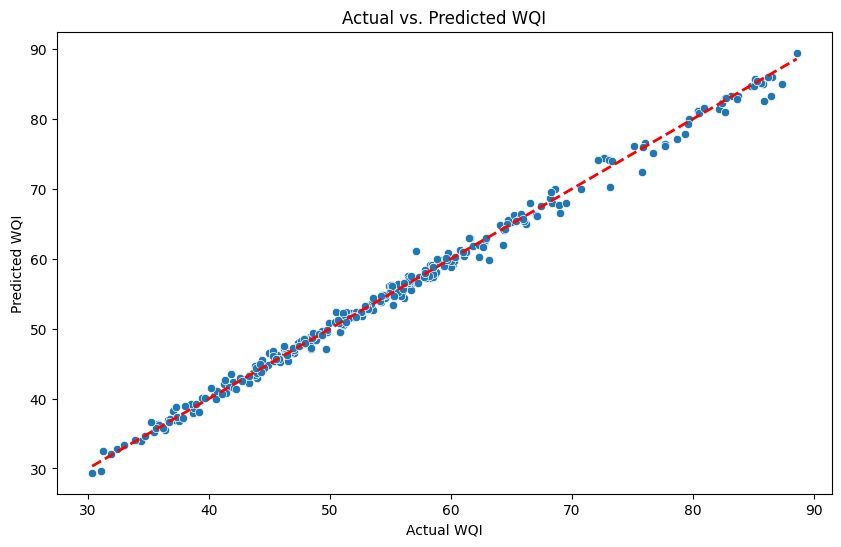

In [16]:

# --- 9. WQI (Regression) Evaluation ---
print("\n--- WQI Model Evaluation ---")
y_pred_r = best_reg.predict(X_test_r_scaled)

r2 = r2_score(y_test_r, y_pred_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))

print(f"Target R-squared (> 95%) vs. Achieved R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# NEW VISUALIZATION: Actual vs. Predicted WQI Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_r, y=y_pred_r)
plt.plot([min(y_test_r), max(y_test_r)], [min(y_test_r), max(y_test_r)], color='red', linestyle='--', lw=2)
plt.title('Actual vs. Predicted WQI')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.show()

In [17]:

# --- 10. Final Summary ---
print("\n--- FINAL RESULTS SUMMARY ---")
print(f"WQC (Classification) Model achieved an accuracy of {accuracy*100:.2f}%.")
print(f"WQI (Regression) Model achieved an R-squared value of {r2:.4f}.")
print("The script has completed all tasks successfully.")



--- FINAL RESULTS SUMMARY ---
WQC (Classification) Model achieved an accuracy of 93.35%.
WQI (Regression) Model achieved an R-squared value of 0.9954.
The script has completed all tasks successfully.


In [18]:
!pip install gradio

In [21]:
import joblib

joblib.dump(best_clf, "/content/classifier.pkl")
joblib.dump(best_reg, "/content/regressor.pkl")
joblib.dump(scaler_c, "/content/scaler_c.pkl")
joblib.dump(scaler_r, "/content/scaler_r.pkl")
joblib.dump(le, "/content/label_encoder.pkl")

print("Models saved in /content")

Models saved in /content


In [22]:
import joblib

clf = joblib.load("/content/classifier.pkl")
reg = joblib.load("/content/regressor.pkl")
scaler_c = joblib.load("/content/scaler_c.pkl")
scaler_r = joblib.load("/content/scaler_r.pkl")
le = joblib.load("/content/label_encoder.pkl")

In [23]:
import numpy as np

def predict_water_quality(temp, do, ph, cond, bod, nitrate, fecal):
    # Prepare input as 2D array
    X = np.array([[temp, do, ph, cond, bod, nitrate, fecal]])

    # Scale features for classification and regression
    X_scaled_c = scaler_c.transform(X)  # WQC classifier
    X_scaled_r = scaler_r.transform(X)  # WQI regressor

    # Make predictions
    wqc_pred = le.inverse_transform(clf.predict(X_scaled_c))[0]
    wqi_pred = reg.predict(X_scaled_r)[0]

    return f"WQC: {wqc_pred}", f"WQI Score: {wqi_pred:.2f}"

In [24]:
import gradio as gr

demo = gr.Interface(
    fn=predict_water_quality,
    inputs=[
        gr.Number(label="Temperature"),
        gr.Number(label="Dissolved Oxygen"),
        gr.Number(label="pH"),
        gr.Number(label="Conductivity"),
        gr.Number(label="BOD"),
        gr.Number(label="Nitrate"),
        gr.Number(label="Fecal Coliform"),
    ],
    outputs=["text", "text"],
    title="Water Quality Prediction",
    description="Enter water parameters to get WQI score and WQC classification"
)

In [25]:
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://34c7c1fca10757e144.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
